
# Densities of CH4-N2 Mixtures

This Code tries to calculate and compare the Densities of CH4-N2 Mixtures. \
We obtain the these from:
1. Using Canteras gri-mech gas object (ideal-gas approximation)
2. Using the Van-der-Waals EOS (non-ideal prediction)
3. CoolProps Backends (should be most accurate)
4. Lentner et als work (Reference)

Sources: \
Cantera Critical State Properties: https://cantera.org/stable/examples/python/thermo/critical_properties.html \
Coolprop Cubic EOS: http://www.coolprop.org/coolprop/Cubics.html \
Coolprop Mixture Handling: http://www.coolprop.org/dev/fluid_properties/Mixtures.html \
Coolprop Low Level Interface: http://www.coolprop.org/coolprop/LowLevelAPI.html
Lentner Paper:

In [49]:
#Imports
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D #Needed for better plots
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
# !pip install pandas if you dont have it
import pandas as pd

In [81]:
#Setting our pressure arrays to roughly the papers bounds
#Avoiding running into phase transition lines (solver doesnt like that)
p100 = 1000000 * np.linspace(0.4, 7.8, 75) #10^6 to get to Pa
p120 = 1000000 * np.linspace(1.1, 8.2, 72) #10^6 to get to Pa
p140 = 1000000 * np.linspace(2.2, 8.9, 68) #10^6 to get to Pa
p160 = 1000000 * np.linspace(4.2, 8.5, 44) #10^6 to get to Pa

In [85]:
print(p160)

[4200000. 4300000. 4400000. 4500000. 4600000. 4700000. 4800000. 4900000.
 5000000. 5100000. 5200000. 5300000. 5400000. 5500000. 5600000. 5700000.
 5800000. 5900000. 6000000. 6100000. 6200000. 6300000. 6400000. 6500000.
 6600000. 6700000. 6800000. 6900000. 7000000. 7100000. 7200000. 7300000.
 7400000. 7500000. 7600000. 7700000. 7800000. 7900000. 8000000. 8100000.
 8200000. 8300000. 8400000. 8500000.]


We first start with Cantera: Getting mixture densities is as simple as setting up a gas object, defining the mass fractions, then querying its properties.

In [86]:
gas1 = ct.Solution ('gri30.yaml')
gas1.X = 'CH4:0.697906, N2:0.302094' #Same as paper

#Setting our Temperature Constants (K)
T100 = 100
T120 = 120
T140 = 140
T160 = 160

#Final value arrays
rho_ct100 = [] 
rho_ct120 = [] 
rho_ct140 = [] 
rho_ct160 = [] 

# Function to compute density for a given temperature and pressure array
def ct_rho_for_temp(T, p_list):
    rho_list = []
    for p1 in p_list:
        gas1.TP = T, p1
        rho = gas1.density     # kg/m³
        rho_list.append(rho)
    return rho_list

# Compute for each temperature and pressure
rho_ct100 = ct_rho_for_temp(T100, p100)
rho_ct120 = ct_rho_for_temp(T120, p120)
rho_ct140 = ct_rho_for_temp(T140, p140)
rho_ct160 = ct_rho_for_temp(T160, p160)

In [88]:
print(rho_ct100)

[9.457913602775507, 11.822392003469384, 14.186870404163258, 16.551348804857138, 18.915827205551015, 21.280305606244887, 23.644784006938767, 26.009262407632644, 28.373740808326517, 30.738219209020393, 33.102697609714276, 35.467176010408146, 37.83165441110203, 40.1961328117959, 42.560611212489775, 44.92508961318366, 47.289568013877535, 49.65404641457141, 52.01852481526528, 54.383003215959164, 56.74748161665303, 59.11196001734691, 61.476438418040786, 63.840916818734655, 66.20539521942855, 68.56987362012242, 70.93435202081629, 73.29883042151016, 75.66330882220404, 78.02778722289793, 80.3922656235918, 82.75674402428567, 85.12122242497955, 87.48570082567343, 89.85017922636732, 92.21465762706119, 94.57913602775507, 96.94361442844892, 99.30809282914282, 101.67257122983669, 104.03704963053056, 106.40152803122446, 108.76600643191833, 111.13048483261221, 113.49496323330607, 115.85944163399995, 118.22392003469383, 120.5883984353877, 122.95287683608159, 125.31735523677547, 127.68183363746934, 130.0

These are too low!
This is due to the chosen mechanism not being fitted for liquids!
Cantera also does not contain a mechanism for liquid CH4 by itself

Now to do Van-der-Waals: All Formulas are from Page 241, 242 of Bell et als Work https://nvlpubs.nist.gov/nistpubs/jres/121/jres.121.011.pdf \
After applying the simplifications ($\Delta$1=$\Delta$2=0, a is not Temperature dependent) the EOS looks more familiar:

$$ p = \frac{RT}{v-b} - \frac{a}{v^2} $$

Simplifying gives us

$$ \frac{RTv^2-a(v-b)}{(v-b)v^2} = p $$

$$ pv^3-(bp+RT)v^2 + av -ab = 0 $$

This is cubic can then be solved numerically using numpy.roots, and converted to a density with $\rho = \frac{M}{v}$

The EOS parameters a and b are directly related to the critical Temperature and Pressure of the Fluid.
Assuming the interaction parameters (kij) are 0 (which should not be the case, but usually is, due to a general lack of data), they can be calculated with:

$$ a = \frac{27}{64} \frac{R^2 T_c^2}{P_c} ; b = \frac{1}{8} \frac{RT_c}{P_c} $$

The mixture parameters need to be calculated from the individual species parameters with:

$$
b_{\text{mix}} = \sum x_i b_{ii}
$$

$$
a_{\text{mix}} = \sum_{i}\sum_{j} x_i x_j \sqrt{a_{ii} a_{jj}}
$$

For this Case with 2 species:

$$
b_{\text{mix}} = x_1 b_1 + x_2 b_2
$$

$$
a_{\text{mix}} = x_1^2a_{1}+x_2^2a_{2} + 2x_{1}x_{2}\sqrt{a_1a_2}
$$

Since we know each single species Tc and Pc, we can:
1. Calculate a and b of each species
2. Apply the mixing rule
3. Solve the cubic of our mixture
4. Convert v to $\rho$

In [89]:
#Array for each species a and b Parameters
fluids = ['CH4','N2']

Par_list = []

for X in fluids:
    name1 = X
    a = 27/64 * pow(ct.gas_constant,2)*pow(PropsSI("Tcrit", X),2)/PropsSI("pcrit", X)
    b = 1/8 * (ct.gas_constant*PropsSI("Tcrit", X))/PropsSI("pcrit", X)
    Par_list.append ((name1,a,b))

#Converting List to Dictionary to make lookup easier
Par_dict = {name: (a, b) for name, a, b in Par_list}

#Now we can Lookup values with Par_dict['SPECIES'][POS]
print(Par_dict)

{'CH4': (230277.5419896273, 0.04306284936417622), 'N2': (136764.6011500549, 0.03862192512478627)}


Now to solve the for amix and bmix

In [90]:
b_mix = (gas1.X[gas1.species_index('N2')]*Par_dict['N2'][1] + gas1.X[gas1.species_index('CH4')]*Par_dict['CH4'][1])
a_mix = pow(gas1.X[gas1.species_index('N2')],2)*Par_dict['N2'][0] \
        + pow(gas1.X[gas1.species_index('CH4')],2)*Par_dict['CH4'][0] \
        + 2*gas1.X[gas1.species_index('N2')]*gas1.X[gas1.species_index('CH4')]*np.sqrt(Par_dict['N2'][0]*Par_dict['CH4'][0])

print(a_mix)
print(b_mix)

199474.18963002283
0.041721272797001954


In [185]:
#Solution Arrays
rho_VdW100 = [] 
rho_VdW120 = [] 
rho_VdW140 = [] 
rho_VdW160 = [] 

# Function, solves for v and calculates rho
def vdw_rho_for_temp(T, p_list):
    rho_list = []
    for P1 in p_list:
        # Cubic has the form: A*x^3 + B*x^2 + C*x + D = 0
        # For us, A=p, B=-(pb+RT), C=a, D=-ab
        A = P1
        B = -(P1 * b_mix + ct.gas_constant * T)
        C = a_mix
        D = - a_mix * b_mix
        v_roots = np.roots([A,B,C,D])
        # Before calculating rho, we need to filter our solution for the positive real roots only:
        positive_roots = v_roots[np.isreal(v_roots) & (np.real(v_roots) > 0)] #Picks roots that are non-complex and positive
        positive_roots = np.real(positive_roots) #Converts picked roots into real numbers, instead of complex a + bi ones
        rho = gas1.mean_molecular_weight/positive_roots
        rho_list.append (rho) #kg/m3
    return rho_list


# Compute for each Temperature
rho_VdW100 = ct_rho_for_temp(T100, p100)
rho_VdW120 = ct_rho_for_temp(T120, p120)
rho_VdW140 = ct_rho_for_temp(T140, p140)
rho_VdW160 = ct_rho_for_temp(T160, p160)

In [184]:
print(rho_VdW100)

[9.457913602775507, 11.822392003469384, 14.186870404163258, 16.551348804857138, 18.915827205551015, 21.280305606244887, 23.644784006938767, 26.009262407632644, 28.373740808326517, 30.738219209020393, 33.102697609714276, 35.467176010408146, 37.83165441110203, 40.1961328117959, 42.560611212489775, 44.92508961318366, 47.289568013877535, 49.65404641457141, 52.01852481526528, 54.383003215959164, 56.74748161665303, 59.11196001734691, 61.476438418040786, 63.840916818734655, 66.20539521942855, 68.56987362012242, 70.93435202081629, 73.29883042151016, 75.66330882220404, 78.02778722289793, 80.3922656235918, 82.75674402428567, 85.12122242497955, 87.48570082567343, 89.85017922636732, 92.21465762706119, 94.57913602775507, 96.94361442844892, 99.30809282914282, 101.67257122983669, 104.03704963053056, 106.40152803122446, 108.76600643191833, 111.13048483261221, 113.49496323330607, 115.85944163399995, 118.22392003469383, 120.5883984353877, 122.95287683608159, 125.31735523677547, 127.68183363746934, 130.0

This mirrors the gri mechs results. This is due to vdw also being fitted for gases!

Now onto CoolProp: We will use CoolProps low level interface to input PT functionally and directly

Additionally, we will specify the phase as liquid (in accordance with the papers phase diagram), so the solver knows which root to pick. Alternatively, we could provide a density guess (haven't figured out how to do that while querying for density)

In [98]:
#HEOS
rho_HEOS100 = []
rho_HEOS120 = []
rho_HEOS140 = []
rho_HEOS160 = []

AS1 = CP.AbstractState("HEOS", "N2&CH4")
AS1.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('CH4')]])

def HEOS_rho_for_temp(T, p_list):
    rho_list = []
    for p1 in p_list:
        AS1.specify_phase(CP.iphase_liquid)
        AS1.update(CP.PT_INPUTS, p1, T)
        rho_list.append (AS1.keyed_output(CP.iDmass)) #kg/m3
    return rho_list

rho_HEOS100 = HEOS_rho_for_temp(T100, p100)
rho_HEOS120 = HEOS_rho_for_temp(T120, p120)
rho_HEOS140 = HEOS_rho_for_temp(T140, p140)
rho_HEOS160 = HEOS_rho_for_temp(T160, p160)

In [99]:
print (rho_HEOS100)

[527.9592522319242, 528.094368063189, 528.2291711873937, 528.363663471625, 528.4978467645799, 528.6317228968206, 528.7652936810246, 528.8985609122286, 529.0315263680747, 529.1641918090406, 529.2965589786801, 529.4286296038476, 529.5604053949227, 529.6918880460343, 529.8230792352746, 529.9539806249146, 530.0845938616144, 530.2149205766254, 530.3449623859981, 530.474720890778, 530.6041976772026, 530.733394316893, 530.8623123670449, 530.9909533706127, 531.1193188564943, 531.2474103397096, 531.3752293215789, 531.5027772898947, 531.6300557190968, 531.7570660704366, 531.8838097921448, 532.0102883195947, 532.1365030754615, 532.2624554698807, 532.3881469006028, 532.5135787531474, 532.6387524009517, 532.7636692055188, 532.8883305165651, 533.0127376721613, 533.1368919988741, 533.2607948119057, 533.3844474152313, 533.5078511017293, 533.6310071533203, 533.7539168410915, 533.8765814254293, 533.9990021561429, 534.1211802725908, 534.2431170038031, 534.3648135686008, 534.4862711757157, 534.60749102390

Highest correspondence with results so far!

In [104]:
#PR
rho_PR100 = []
rho_PR120 = []
rho_PR140 = []
rho_PR160 = []

AS2 = CP.AbstractState("PR", "N2&CH4")
AS2.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('CH4')]])

def PR_rho_for_temp(T, p_list):
    rho_list = []
    for p1 in p_list:
        AS2.specify_phase(CP.iphase_liquid)
        AS2.update(CP.PT_INPUTS, p1, T)
        rho_list.append (AS2.keyed_output(CP.iDmass)) #kg/m3
    return rho_list

rho_PR100 = PR_rho_for_temp(T100, p100)
rho_PR120 = PR_rho_for_temp(T120, p120)
rho_PR140 = PR_rho_for_temp(T140, p140)
rho_PR160 = PR_rho_for_temp(T160, p160)

In [105]:
print (rho_PR100)

[601.6307496300759, 601.7900295547126, 601.9488165850534, 602.1071136988915, 602.264923846125, 602.422249949115, 602.5790949030352, 602.7354615762197, 602.8913528105012, 603.0467714215474, 603.201720199189, 603.3562019077444, 603.5102192863382, 603.6637750492154, 603.8168718860494, 603.9695124622473, 604.1216994192478, 604.2734353748162, 604.4247229233348, 604.5755646360873, 604.7259630615407, 604.8759207256212, 605.0254401319871, 605.1745237622966, 605.3231740764722, 605.4713935129607, 605.6191844889889, 605.7665494008163, 605.9134906239836, 606.0600105135568, 606.2061114043687, 606.351795611256, 606.4970654292939, 606.641923134025, 606.786370981688, 606.9304112094402, 607.0740460355782, 607.217277659755, 607.3601082631941, 607.5025400088997, 607.6445750418653, 607.7862154892782, 607.9274634607206, 608.0683210483694, 608.208790327192, 608.3488733551386, 608.4885721733349, 608.6278888062669, 608.7668252619687, 608.905383532203, 609.0435655926426, 609.1813734030463, 609.3188089074354, 6

In [106]:
#SRK
rho_SRK100 = []
rho_SRK120 = []
rho_SRK140 = []
rho_SRK160 = []

AS3 = CP.AbstractState("SRK", "N2&CH4")
AS3.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('CH4')]])

def SRK_rho_for_temp(T, p_list):
    rho_list = []
    for p1 in p_list:
        AS3.specify_phase(CP.iphase_liquid)
        AS3.update(CP.PT_INPUTS, p1, T)
        rho_list.append (AS3.keyed_output(CP.iDmass)) #kg/m3
    return rho_list

rho_SRK100 = PR_rho_for_temp(T100, p100)
rho_SRK120 = PR_rho_for_temp(T120, p120)
rho_SRK140 = PR_rho_for_temp(T140, p140)
rho_SRK160 = PR_rho_for_temp(T160, p160)

In [107]:
print (rho_SRK100)

[601.6307496300759, 601.7900295547126, 601.9488165850534, 602.1071136988915, 602.264923846125, 602.422249949115, 602.5790949030352, 602.7354615762197, 602.8913528105012, 603.0467714215474, 603.201720199189, 603.3562019077444, 603.5102192863382, 603.6637750492154, 603.8168718860494, 603.9695124622473, 604.1216994192478, 604.2734353748162, 604.4247229233348, 604.5755646360873, 604.7259630615407, 604.8759207256212, 605.0254401319871, 605.1745237622966, 605.3231740764722, 605.4713935129607, 605.6191844889889, 605.7665494008163, 605.9134906239836, 606.0600105135568, 606.2061114043687, 606.351795611256, 606.4970654292939, 606.641923134025, 606.786370981688, 606.9304112094402, 607.0740460355782, 607.217277659755, 607.3601082631941, 607.5025400088997, 607.6445750418653, 607.7862154892782, 607.9274634607206, 608.0683210483694, 608.208790327192, 608.3488733551386, 608.4885721733349, 608.6278888062669, 608.7668252619687, 608.905383532203, 609.0435655926426, 609.1813734030463, 609.3188089074354, 6

Lets now export the Data to csv for easier comparison

In [115]:
#First create the Dataframes

#100K
df100 = pd.DataFrame({
    'Pressure (atm)': p100,
    'Cantera GRI Density @100K (kg/m3)': rho_ct100,
    'VdW Predicted Density @100K (kg/m3)': rho_VdW100,
    'CP PR Density @100K (kg/m3)': rho_PR100,
    'CP SRK Density @100K (kg/m3)': rho_SRK100,
    'CP HEOS Density @100K (kg/m3)': rho_HEOS100,
    'Notes': [''] * len(p100),
})

#120K
df120 = pd.DataFrame({
    'Pressure (atm)': p120,
    'Cantera GRI Density @120K (kg/m3)': rho_ct120,
    'VdW Predicted Density @120K (kg/m3)': rho_VdW120,
    'CP PR Density @120K (kg/m3)': rho_PR120,
    'CP SRK Density @120K (kg/m3)': rho_SRK120,
    'CP HEOS Density @120K (kg/m3)': rho_HEOS120,
    'Notes': [''] * len(p120),
})

#140K
df140 = pd.DataFrame({
    'Pressure (atm)': p140,
    'Cantera GRI Density @140K (kg/m3)': rho_ct140,
    'VdW Predicted Density @140K (kg/m3)': rho_VdW140,
    'CP PR Density @140K (kg/m3)': rho_PR140,
    'CP SRK Density @140K (kg/m3)': rho_SRK140,
    'CP HEOS Density @140K (kg/m3)': rho_HEOS140,
    'Notes': [''] * len(p140),
})

#160K
df160 = pd.DataFrame({
    'Pressure (atm)': p160,
    'Cantera GRI Density @160K (kg/m3)': rho_ct160,
    'VdW Predicted Density @160K (kg/m3)': rho_VdW160,
    'CP PR Density @160K (kg/m3)': rho_PR160,
    'CP SRK Density @160K (kg/m3)': rho_SRK160,
    'CP HEOS Density @160K (kg/m3)': rho_HEOS160,
    'Notes': [''] * len(p160),
})

In [118]:
#Now export

df100.to_csv('DataResults/CH4-N2_Densities_100K.csv', index=False)
df120.to_csv('DataResults/CH4-N2_Densities_120K.csv', index=False)
df140.to_csv('DataResults/CH4-N2_Densities_140K.csv', index=False)
df160.to_csv('DataResults/CH4-N2_Densities_160K.csv', index=False)

Importing reference data for plotting here

In [133]:
rhoReference = pd.read_csv('Fluid Reference Data/LentnerCH4N2 Densities.csv')

In [134]:
%config InlineBackend.figure_formats = ['svg'] #Looks better!

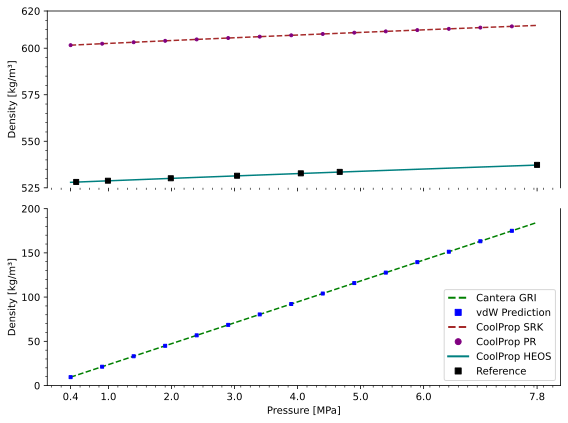

In [192]:
# Create a figure and subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(p100 / 1000000, rho_PR100, '--', color='brown', label='$SRK$')
ax1.plot(p100 / 1000000, rho_SRK100, ' ', color='purple', marker='o', markersize=3, markevery=5, label='$PR$')
ax1.plot(p100 / 1000000, rho_HEOS100, '-', color='teal', label='$HEOS$')
ax1.plot(rhoReference['p100 (MPa)'], rhoReference['rho100 (kg/m3)'], ' ', color='black', marker='s', markersize=5, label='$Reference$')
ax1.set_ylim(525, 620)
ax1.set_ylabel('Density [kg/m3]')

ax2.plot(p100 / 1000000, rho_ct100, 'g--', label='$CT rho$')
ax2.plot(p100 / 1000000, rho_VdW100, ' ', color='b', marker='s', markersize=3, markevery=5, label='$VdW$')
ax2.set_ylim(0, 200)
ax2.set_ylabel('Density [kg/m3]')
ax2.set_xlabel('Pressure [MPa]')

ax1.set_xticks([0.4, 1, 2, 3, 4, 5, 6, 7.8])
ax2.set_xticks([0.4, 1, 2, 3, 4, 5, 6, 7.8])
ax2.set_yticks([0, 50, 100, 150, 200])
ax1.set_yticks([525, 550, 575, 600, 620])
ax1.minorticks_on()
ax2.minorticks_on()

custom_legend_lines = [
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Cantera GRI'),
    Line2D([0], [0], color='blue', lw=2, linestyle=' ', marker='s', label='vdW Prediction'),
    Line2D([0], [0], color='brown', lw=2, linestyle='--', label='CoolProp SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle='-', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='Reference'),
]
ax2.legend(handles=custom_legend_lines, loc='lower right')


# Removing spines to create a clean break between the axes
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add a visual break between the axes using a line
d = 0.01  # fraction of the figure height
kwargs = dict(marker=[3, 1, 0], markersize=10, color="k", linestyle="None")
ax1.plot([0.5, 0.5], [1-d, 1], **kwargs)  # Break line

plt.tight_layout()

plt.savefig("Graphs/rho_CH4_N2_100K.svg")
plt.show()

HEOS is spot on with reference. \
CT and Van der Waals underpredict majorly due to a wrong phase assumption (fitted for gasses!). \

CoolProp SRK and PR overpredict consistently, but are getting closer: These models need more fitting. We will try tweaking BIPs for one of the cases below. For now, lets finish the Graphs!

Overall, good results! There are some per-model disagreements, but no fundamental issues!

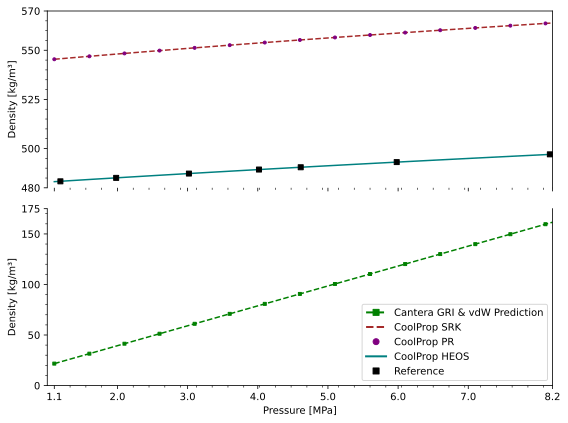

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(p120 / 1000000, rho_PR120, '--', color='brown', label='$SRK$')
ax1.plot(p120 / 1000000, rho_SRK120, ' ', color='purple', marker='o', markersize=3, markevery=5, label='$PR$')
ax1.plot(p120 / 1000000, rho_HEOS120, '-', color='teal', label='$HEOS$')
ax1.plot(rhoReference['p120 (MPa)'], rhoReference['rho120 (kg/m3)'], ' ', color='black', marker='s', markersize=5, label='$Reference$')
ax1.set_ylim(480, 570)
ax1.set_ylabel('Density [kg/m3]')

ax2.plot(p120 / 1000000, rho_ct120, 'g--', label='$CT rho$')
ax2.plot(p120 / 1000000, rho_VdW120, ' ', color='green', marker='s', markersize=3, markevery=5, label='$VdW$')
ax2.set_ylim(0, 175)
ax2.set_ylabel('Density [kg/m3]')
ax2.set_xlabel('Pressure [MPa]')

ax1.set_xlim(1, 8.2)
ax2.set_xlim(1, 8.2)
ax1.set_xticks([1.1, 2, 3, 4, 5, 6, 7, 8.2])
ax2.set_xticks([1.1, 2, 3, 4, 5, 6, 7, 8.2])
ax2.set_yticks([0, 50, 100, 150, 175])
ax1.set_yticks([480, 500, 525, 550, 570])
ax1.minorticks_on()
ax2.minorticks_on()

custom_legend_lines = [
    Line2D([0], [0], color='green', lw=2, linestyle='--', marker='s', label='Cantera GRI & vdW Prediction'),
    Line2D([0], [0], color='brown', lw=2, linestyle='--', label='CoolProp SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle='-', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='Reference'),
]
ax2.legend(handles=custom_legend_lines, loc='lower right')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = 0.01
kwargs = dict(marker=[3, 1, 0], markersize=10, color="k", linestyle="None")
ax1.plot([0.5, 0.5], [1-d, 1], **kwargs)

plt.tight_layout()

plt.savefig("Graphs/rho_CH4_N2_120K.svg")
plt.show()

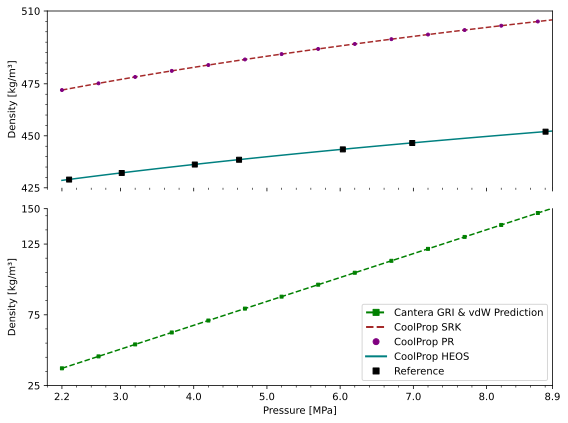

In [203]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(p140 / 1000000, rho_PR140, '--', color='brown', label='$SRK$')
ax1.plot(p140 / 1000000, rho_SRK140, ' ', color='purple', marker='o', markersize=3, markevery=5, label='$PR$')
ax1.plot(p140 / 1000000, rho_HEOS140, '-', color='teal', label='$HEOS$')
ax1.plot(rhoReference['p140 (MPa)'], rhoReference['rho140 (kg/m3)'], ' ', color='black', marker='s', markersize=5, label='$Reference$')
ax1.set_ylim(425, 510)
ax1.set_ylabel('Density [kg/m3]')

ax2.plot(p140 / 1000000, rho_ct140, 'g--', label='$CT rho$')
ax2.plot(p140 / 1000000, rho_VdW140, ' ', color='green', marker='s', markersize=3, markevery=5, label='$VdW$')
ax2.set_ylim(25, 150)
ax2.set_ylabel('Density [kg/m3]')
ax2.set_xlabel('Pressure [MPa]')

ax1.set_xlim(2, 8.9)
ax2.set_xlim(2, 8.9)
ax1.set_xticks([2.2, 3, 4, 5, 6, 7, 8, 8.9])
ax2.set_xticks([2.2, 3, 4, 5, 6, 7, 8, 8.9])
ax2.set_yticks([25, 75, 125, 150])
ax1.set_yticks([425, 450, 475, 510])
ax1.minorticks_on()
ax2.minorticks_on()

custom_legend_lines = [
    Line2D([0], [0], color='green', lw=2, linestyle='--', marker='s', label='Cantera GRI & vdW Prediction'),
    Line2D([0], [0], color='brown', lw=2, linestyle='--', label='CoolProp SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle='-', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='Reference'),
]
ax2.legend(handles=custom_legend_lines, loc='lower right')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = 0.01
kwargs = dict(marker=[3, 1, 0], markersize=10, color="k", linestyle="None")
ax1.plot([0.5, 0.5], [1-d, 1], **kwargs)

plt.tight_layout()

plt.savefig("Graphs/rho_CH4_N2_140K.svg")
plt.show()

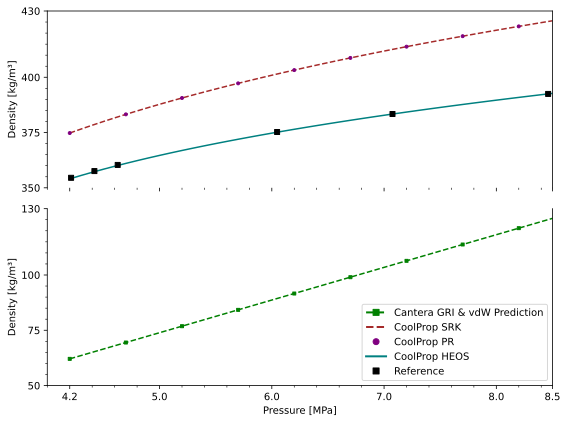

In [210]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(p160 / 1000000, rho_PR160, '--', color='brown', label='$SRK$')
ax1.plot(p160 / 1000000, rho_SRK160, ' ', color='purple', marker='o', markersize=3, markevery=5, label='$PR$')
ax1.plot(p160 / 1000000, rho_HEOS160, '-', color='teal', label='$HEOS$')
ax1.plot(rhoReference['p160 (MPa)'], rhoReference['rho160 (kg/m3)'], ' ', color='black', marker='s', markersize=5, label='$Reference$')
ax1.set_ylim(350, 430)
ax1.set_ylabel('Density [kg/m3]')

ax2.plot(p160 / 1000000, rho_ct160, 'g--', label='$CT rho$')
ax2.plot(p160 / 1000000, rho_VdW160, ' ', color='green', marker='s', markersize=3, markevery=5, label='$VdW$')
ax2.set_ylim(50, 130)
ax2.set_ylabel('Density [kg/m3]')
ax2.set_xlabel('Pressure [MPa]')

ax1.set_xlim(4, 8.5)
ax2.set_xlim(4, 8.5)
ax1.set_xticks([4.2, 5, 6, 7, 8, 8.5])
ax2.set_xticks([4.2, 5, 6, 7, 8, 8.5])
ax2.set_yticks([50, 75, 100, 130])
ax1.set_yticks([350, 375, 400, 430])
ax1.minorticks_on()
ax2.minorticks_on()

custom_legend_lines = [
    Line2D([0], [0], color='green', lw=2, linestyle='--', marker='s', label='Cantera GRI & vdW Prediction'),
    Line2D([0], [0], color='brown', lw=2, linestyle='--', label='CoolProp SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle='-', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='Reference'),
]
ax2.legend(handles=custom_legend_lines, loc='lower right')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = 0.01
kwargs = dict(marker=[3, 1, 0], markersize=10, color="k", linestyle="None")
ax1.plot([0.5, 0.5], [1-d, 1], **kwargs)

plt.tight_layout()

plt.savefig("Graphs/rho_CH4_N2_160K.svg")
plt.show()

We will try changing the BIPs for the 160K case (since its closest to reference)

In [211]:
AS_PRmod = CP.AbstractState("PR", "N2&CH4")
AS_SRKmod = CP.AbstractState("SRK", "N2&CH4")

print ('Interaction Parameters of CH4-N2 for PR:')
print(AS_PRmod.get_binary_interaction_double(0,1,"kij"))
print ('Interaction Parameters of CH4-N2 for SRK:')
print(AS_SRKmod.get_binary_interaction_double(0,1,"kij"))

#All Parameters are 0 (standard value)

Interaction Parameters of CH4-N2 for PR:
0.0
Interaction Parameters of CH4-N2 for SRK:
0.0


In [222]:
AS_PRmod.set_binary_interaction_double(0, 1, "kij", -0.5)
AS_SRKmod.set_binary_interaction_double(0, 1, "kij", -0.5)

print(AS_SRKmod.get_binary_interaction_double(0,1,"kij"))

-0.5


In [223]:
AS_PRmod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('CH4')]])
AS_SRKmod.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('CH4')]])

rho_SRKmod = []
rho_PRmod = []

for p2 in p160:
    AS_PRmod.specify_phase(CP.iphase_liquid)
    AS_PRmod.update(CP.PT_INPUTS, p2, T160)
    rho_PRmod.append (AS_PRmod.keyed_output(CP.iDmass)) #kg/m3

for p3 in p160:
    AS_SRKmod.specify_phase(CP.iphase_liquid)
    AS_SRKmod.update(CP.PT_INPUTS, p3, T160)
    rho_SRKmod.append (AS_SRKmod.keyed_output(CP.iDmass)) #kg/m3

In [224]:
#Convert lists to np arrays to subtract them
rho_SRKmod_array = np.array(rho_SRKmod)
rho_HEOS160_array = np.array(rho_HEOS160)

diff = rho_SRKmod_array - rho_HEOS160_array
print(diff)

[60.00996096 59.05250685 58.15443438 57.3096008  56.51277521 55.75946331
 55.04577292 54.36830933 53.72409274 53.11049243 52.52517359 51.96605409
 51.43126894 50.91914088 50.42815583 49.95694223 49.50425367 49.06895405
 48.65000488 48.24645446 47.85742842 47.48212161 47.11979098 46.76974941
 46.43136021 46.1040324  45.7872164  45.48040033 45.18310665 44.89488919
 44.61533049 44.34403944 44.0806491  43.82481479 43.57621237 43.33453666
 43.09949999 42.87083092 42.64827311 42.43158415 42.22053469 42.01490746
 41.8144965  41.61910638]


Thats too low!

Lets instead do a simple search to find a better BIP. From our test we know it should be close to 0

In [295]:
kij1_list = np.linspace(-0.125,0.125,25001)
print(kij1_list)

[-0.125   -0.12499 -0.12498 ...  0.12498  0.12499  0.125  ]


In [296]:
SRK_best_kij = None
PR_best_kij = None
SRK_min_error = np.inf
PR_min_error = np.inf

# convert to np array to work with values
rho_HEOS160_array = np.array(rho_HEOS160)

for kij1 in kij1_list:
    rho_SRKmod = []
    rho_PRmod = []
    
    # Set kij
    AS_SRKmod.set_binary_interaction_double(0, 1, "kij", kij1)
    AS_PRmod.set_binary_interaction_double(0, 1, "kij", kij1)

    # Calculate densities as above
    for p in p160:
        AS_SRKmod.specify_phase(CP.iphase_liquid)
        AS_SRKmod.update(CP.PT_INPUTS, p, T160)
        rho_SRKmod.append(AS_SRKmod.keyed_output(CP.iDmass))
        
        AS_PRmod.specify_phase(CP.iphase_liquid)
        AS_PRmod.update(CP.PT_INPUTS, p, T160)
        rho_PRmod.append(AS_PRmod.keyed_output(CP.iDmass))

    # Convert to np arrays, same as HEOS
    rho_SRKmod_array = np.array(rho_SRKmod)
    rho_PRmod_array = np.array(rho_PRmod)

    # Compute absolute errors
    SRK_error = np.nanmean(np.abs(rho_SRKmod_array - rho_HEOS160_array))
    PR_error = np.nanmean(np.abs(rho_PRmod_array - rho_HEOS160_array))

    #Compare errors
    if SRK_error < SRK_min_error:
        SRK_min_error = SRK_error
        SRK_best_kij = kij1
    
    if PR_error < PR_min_error:
        PR_min_error = PR_error
        PR_best_kij = kij1


print(f"Best kij1 value for SRK: {SRK_best_kij}")
print(f"Best kij1 value for PR: {PR_best_kij}")

Best kij1 value for SRK: -0.10239999999999999
Best kij1 value for PR: 0.10663000000000003


Now lets see how close we got:

In [297]:
AS_SRKmod.set_binary_interaction_double(0, 1, "kij", SRK_best_kij)
AS_PRmod.set_binary_interaction_double(0, 1, "kij", PR_best_kij)

rho_SRKmod = []
rho_PRmod = []

for p2 in p160:
    AS_PRmod.specify_phase(CP.iphase_liquid)
    AS_PRmod.update(CP.PT_INPUTS, p2, T160)
    rho_PRmod.append (AS_PRmod.keyed_output(CP.iDmass)) #kg/m3

for p3 in p160:
    AS_SRKmod.specify_phase(CP.iphase_liquid)
    AS_SRKmod.update(CP.PT_INPUTS, p3, T160)
    rho_SRKmod.append (AS_SRKmod.keyed_output(CP.iDmass)) #kg/m3

In [298]:
#Convert lists to np arrays to subtract them
rho_SRKmod_array = np.array(rho_SRKmod)
rho_PRmod_array = np.array(rho_PRmod)
rho_HEOS160_array = np.array(rho_HEOS160)

diff_SRK = rho_SRKmod_array - rho_HEOS160_array
diff_PR = rho_PRmod_array - rho_HEOS160_array

In [299]:
print(f"Difference between SRK and HEOOS:")
print(diff_SRK)
print(f"Difference between PR and HEOOS:")
print(diff_PR)

Difference between SRK and HEOOS:
[ 1.94143662e+00  1.62561848e+00  1.34855804e+00  1.10527872e+00
  8.91620836e-01  7.04076339e-01  5.39663190e-01  3.95828346e-01
  2.70371930e-01  1.61387276e-01  6.72130172e-02 -1.36055561e-02
 -8.23479278e-02 -1.40144134e-01 -1.87996051e-01 -2.26795096e-01
 -2.57337041e-01 -2.80334468e-01 -2.96427320e-01 -3.06191860e-01
 -3.10148334e-01 -3.08767540e-01 -3.02476492e-01 -2.91663314e-01
 -2.76681498e-01 -2.57853602e-01 -2.35474495e-01 -2.09814188e-01
 -1.81120340e-01 -1.49620453e-01 -1.15523824e-01 -7.90232678e-02
 -4.02966558e-02  4.91720205e-04  4.31899260e-02  8.76572933e-02
  1.33763440e-01  1.81387391e-01  2.30416785e-01  2.80747163e-01
  3.32281321e-01  3.84928727e-01  4.38604991e-01  4.93231388e-01]
Difference between PR and HEOOS:
[-1.67677722e+01 -1.53309460e+01 -1.39878230e+01 -1.27256605e+01
 -1.15342280e+01 -1.04051819e+01 -9.33162343e+00 -8.30778001e+00
 -7.32876984e+00 -6.39042536e+00 -5.48915849e+00 -4.62185645e+00
 -3.78580013e+00 -2.97

Very close! How would this look graphically?

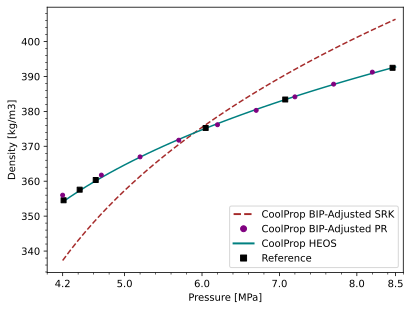

In [325]:
fig, ax1 = plt.subplots()
ax1.plot(p160 / 1000000, rho_PRmod, '--', color='brown', label='$SRK$')
ax1.plot(p160 / 1000000, rho_HEOS160, '-', color='teal', label='$HEOS$')
ax1.plot(rhoReference['p160 (MPa)'], rhoReference['rho160 (kg/m3)'], ' ', color='black', marker='s', markersize=5, label='$Reference$')
ax1.plot(p160 / 1000000, rho_SRKmod, ' ', color='purple', marker='o', markersize=4, markevery=5, label='$PR$')

ax1.set_ylabel('Density [kg/m3]')
ax1.set_xlabel('Pressure [MPa]')
#ax1.set_ylim(350, 430)
ax1.set_xlim(4, 8.6)
ax1.set_xticks([4.2, 5, 6, 7, 8, 8.5])
#ax1.set_yticks([340, 350, 360, 370])
ax1.minorticks_on()

custom_legend_lines = [
    Line2D([0], [0], color='brown', lw=2, linestyle='--', label='CoolProp BIP-Adjusted SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp BIP-Adjusted PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle='-', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='s', label='Reference'),
]
ax1.legend(handles=custom_legend_lines, loc='lower right')
plt.savefig("Graphs/rho_CH4_N2_160K_ModifiedBIPs.svg")
plt.show()

SRK comes close when adjusting BIPs, PR likely needs additional corrections besides the BIP

It is also interesting to note that the two EOSs respond differently to the kij parameter being adjusted

As such, the tuning is a mixed success

In [321]:
# Saving the values in a Dataframe

# Create the data rows and compute deviation
dfmod_data = pd.DataFrame({
    'Pressure (atm)': p160,
    'BIP Adjusted CP SRK Density @160K (kg/m3)': rho_SRKmod,
    'SRK-HEOS Deviation (%)': 100 * (pd.Series(rho_SRKmod) - pd.Series(rho_HEOS160)) / pd.Series(rho_HEOS160),
    'BIP Adjusted CP PR Density @160K (kg/m3)': rho_PRmod,
    'PR-HEOS Deviation (%)': 100 * (pd.Series(rho_PRmod) - pd.Series(rho_HEOS160)) / pd.Series(rho_HEOS160),
    'CP HEOS Density @160K (kg/m3)': rho_HEOS160,
})

# Create a "header row" with BIP values
header_row = pd.DataFrame([{
    'Pressure (atm)': 'BIPs:',
    'BIP Adjusted CP SRK Density @160K (kg/m3)': SRK_best_kij,
    'BIP Adjusted CP PR Density @160K (kg/m3)': PR_best_kij
}])

# Combine them
dfmod = pd.concat([header_row, dfmod_data], ignore_index=True)

In [319]:
dfmod.to_csv('DataResults/CH4-N2_Densities_160K_BIPAdjusted.csv', index=False)